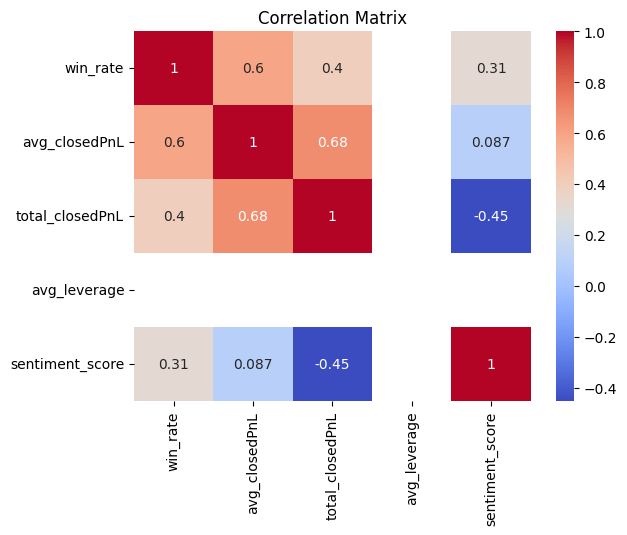

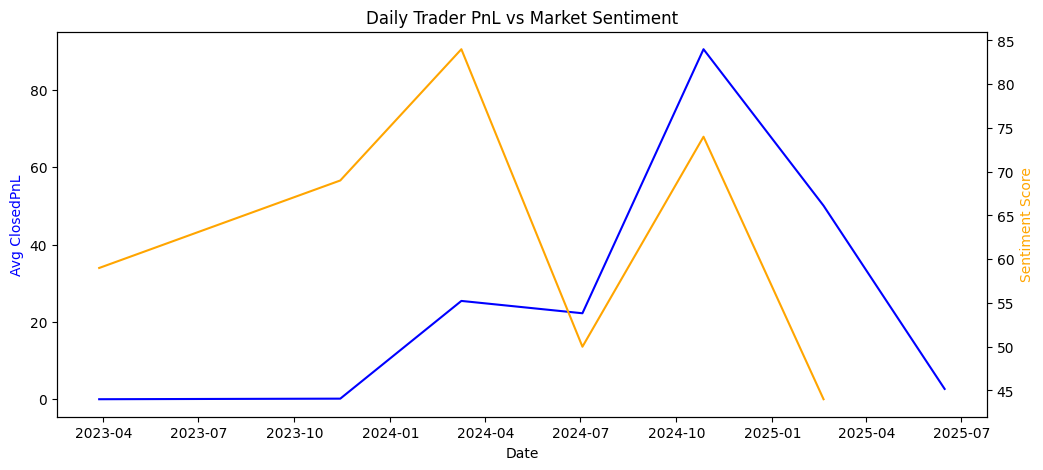

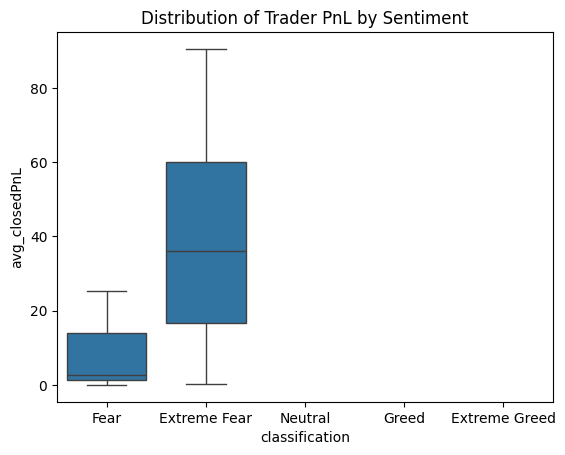

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

HIST_PATH_CANDIDATES = [
    '/mnt/data/historical_data.csv',
    'historical_data.csv'
]
SENT_PATH_CANDIDATES = [
    '/mnt/data/fear_greed_index.csv',
    'fear_greed_index.csv'
]
OUTPUT_DIR = '/mnt/data'
os.makedirs(OUTPUT_DIR, exist_ok=True)

def find_existing_path(candidates):
    for p in candidates:
        if os.path.exists(p):
            return p
    return candidates[0]

def detect_and_parse_datetime(df, prefer_column=None, name_hint=None):
    if prefer_column and prefer_column in df.columns:
        series = _try_parse_series_to_datetime(df[prefer_column])
        if series.notna().sum() > 0:
            return series, prefer_column
    candidates = [c for c in df.columns if any(k in c.lower() for k in ['time','date','timestamp','ts'])]
    best = None
    best_notnull = -1
    for c in candidates:
        series = _try_parse_series_to_datetime(df[c])
        nonnull = series.notna().sum()
        if nonnull > best_notnull:
            best_notnull = nonnull
            best = (series, c)
    if best is None or best_notnull == 0:
        for c in df.columns:
            series = _try_parse_series_to_datetime(df[c])
            nonnull = series.notna().sum()
            if nonnull > best_notnull:
                best_notnull = nonnull
                best = (series, c)
    if best is None:
        raise ValueError(f"No parseable datetime column found (hint: {name_hint})")
    return best

def _try_parse_series_to_datetime(s):
    if pd.api.types.is_numeric_dtype(s):
        mx = s.dropna().abs().max() if s.dropna().shape[0] > 0 else 0
        try:
            if mx > 3e11:
                return pd.to_datetime(s, unit='ms', origin='unix', errors='coerce')
            elif mx > 1e9:
                return pd.to_datetime(s, unit='s', origin='unix', errors='coerce')
            else:
                return pd.to_datetime(s, errors='coerce')
        except Exception:
            return pd.to_datetime(s, errors='coerce')
    else:
        try:
            return pd.to_datetime(s, errors='coerce')
        except Exception:
            return pd.Series([pd.NaT]*len(s))

def find_column_by_keywords(df, keywords, prefer=None):
    if prefer:
        for p in prefer:
            if p in df.columns:
                return p
    for k in keywords:
        for c in df.columns:
            if k in c.lower():
                return c
    return None

hist_path = find_existing_path(HIST_PATH_CANDIDATES)
sent_path = find_existing_path(SENT_PATH_CANDIDATES)

hist = pd.read_csv(hist_path)
sent = pd.read_csv(sent_path)

hist_datetime_series, hist_datetime_col = detect_and_parse_datetime(hist, name_hint='historical_data')
hist['datetime'] = hist_datetime_series
hist['date'] = hist['datetime'].dt.date

sent_pref = None
for prefer in ['date','day','time','timestamp']:
    if prefer in sent.columns:
        sent_pref = prefer
        break

sent_datetime_series, sent_datetime_col = detect_and_parse_datetime(sent, prefer_column=sent_pref, name_hint='sentiment')
sent['datetime'] = sent_datetime_series
sent['date'] = sent['datetime'].dt.date

sent_score_col = find_column_by_keywords(sent, ['value','score','index','val'])
sent_label_col = find_column_by_keywords(sent, ['class','label','classification'])

if sent_score_col:
    sent['sentiment_score'] = pd.to_numeric(sent[sent_score_col], errors='coerce')
else:
    mapping = {'Extreme Fear':0,'Fear':25,'Neutral':50,'Greed':75,'Extreme Greed':100}
    sent['sentiment_score'] = sent[sent_label_col].map(mapping)

hist['closedPnL'] = pd.to_numeric(hist.get('Closed PnL', pd.Series([np.nan]*len(hist))), errors='coerce')
hist['leverage'] = pd.to_numeric(hist.get('leverage', pd.Series([np.nan]*len(hist))), errors='coerce')
hist['size'] = pd.to_numeric(hist.get('Size USD', pd.Series([np.nan]*len(hist))), errors='coerce')
hist['is_profit'] = hist['closedPnL'] > 0

daily = hist.groupby('date').agg(
    trades_count=('closedPnL','count'),
    profitable_trades=('is_profit','sum'),
    win_rate=('is_profit', lambda x: x.mean()),
    avg_closedPnL=('closedPnL','mean'),
    total_closedPnL=('closedPnL','sum'),
    avg_leverage=('leverage','mean'),
    avg_size=('size','mean')
).reset_index()

merged = pd.merge(daily, sent[['date','sentiment_score']], on='date', how='left')

corr = merged[['win_rate','avg_closedPnL','total_closedPnL','avg_leverage','sentiment_score']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(merged['date'], merged['avg_closedPnL'], color='blue', label='Avg ClosedPnL')
ax2 = ax1.twinx()
ax2.plot(merged['date'], merged['sentiment_score'], color='orange', label='Sentiment Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Avg ClosedPnL', color='blue')
ax2.set_ylabel('Sentiment Score', color='orange')
plt.title("Daily Trader PnL vs Market Sentiment")
plt.show()

sns.boxplot(x=sent[sent_label_col], y=merged['avg_closedPnL'])
plt.title("Distribution of Trader PnL by Sentiment")
plt.show()

merged.to_csv(os.path.join(OUTPUT_DIR, "daily_merged_summary.csv"), index=False)
